In [1]:
import os
from analytics_utils.spark_utils import add_pyspark_path
spark_home =  '/usr/hdp/current/spark-client/'
add_pyspark_path(spark_home)
from pyspark import SparkContext
from pyspark.sql import HiveContext


import pyspark.sql.functions as F
from pyspark.sql.functions import udf
from pyspark.sql.window import Window
from pyspark.sql.types import *

max_executors = 25

python_3_path = "/mnt/home/brayere/pyspark3/bin/python"
archive = "/mnt/home/brayere/pyspark3.tar.gz#pyspark3"

NOTEBOOK_NAME = "Discover Analytics FR"


def init_spark():
    # spark submit
    os.environ['PYSPARK_PYTHON'] = "./pyspark3/pyspark3/bin/python"
    os.environ['PYSPARK_SUBMIT_ARGS'] = \
    '--verbose ' \
    '--jars /usr/hdp/current/hadoop-client/hadoop-azure.jar,/usr/hdp/current/hadoop-client/lib/azure-storage-2.2.0.jar ' \
    '--master yarn ' \
    '--deploy-mode client ' \
    '--driver-cores 2 --driver-memory 8g ' \
    '--executor-cores 1 --executor-memory 3g ' \
    '--archives "{archive}" ' \
    '--conf spark.executorEnv.PYTHONHASHSEED=0 ' \
    '--conf spark.dynamicAllocation.maxExecutors={max_executors} ' \
    '--conf spark.shuffle.service.enabled=true ' \
    '--conf spark.dynamicAllocation.enabled=true ' \
    '--conf spark.sql.parquet.compression.codec=snappy ' \
    'pyspark-shell'.format(max_executors=max_executors, 
                           archive=archive)

    # spark context
    sc = SparkContext(appName=NOTEBOOK_NAME, sparkHome=spark_home)
    sc.setLogLevel('ERROR')
    
    # sql context
    sql_context = HiveContext(sparkContext=sc)
    return sc, sql_context

try:
    sc, sql_context = init_spark()
except ValueError:
    sc.stop()
    sc, sql_context = init_spark()

In [2]:
from analytics_utils.data_feeds import DataFeeds
from analytics_utils.feeds import VeCapture, AppNexus
import analytics_utils.reports as reports
from analytics_utils import ve_funcs, ve_utils

from collections import Counter
import pandas as pd

### 1. Loading feeds

In [3]:
from_date, to_date = "2016-07-01", "2016-07-15"

countries = ['FR']

standard_feed = DataFeeds.get_feed_parquet(sql_context, AppNexus.standard, 
                                           from_date=from_date, to_date=to_date, countries=['FR'])
segment_feed =  DataFeeds.get_feed_parquet(sql_context, AppNexus.segment, 
                                           from_date=from_date, to_date=to_date)
pixel_feed = DataFeeds.get_feed_parquet(sql_context, AppNexus.pixel, 
                                        from_date=from_date, to_date=to_date)

page_feed = DataFeeds.get_feed_parquet(sql_context, VeCapture.page_view, 
                                       from_date=from_date, to_date=to_date)
categ_30d_feed =  DataFeeds.get_feed_parquet(sql_context, VeCapture.category_30d, 
                                             from_date=from_date, to_date=to_date)
categorizer_feed = DataFeeds.get_feed_parquet(sql_context, VeCapture.categorizer,
                                             from_date=from_date, to_date=to_date)


### 2. Getting the mapping from the Appnexus API

In [4]:
from appnexus_api import APIHandler

def get_mapping(api, df):
    mapping = {}
    for f, name in [(api.get_insertion_order, 'insertion_order_id'), 
                    (api.get_line_item, 'line_items'),
                    (api.get_pixel, 'pixel_id'), 
                    (api.get_advertiser, 'advertiser_id')]:
        mapping["{}_name".format(name).replace('_id', '')] = APIHandler.bulk_requests(f, df[name].unique().tolist())
    return mapping

In [5]:
%%time
mappings_df = standard_feed.select(
                   standard_feed['advertiser_id'],
                   standard_feed['campaign_group_id'].alias('line_items'),
                   standard_feed['insertion_order_id'],
                   standard_feed['pixel_id']).distinct().toPandas()

CPU times: user 56 ms, sys: 4 ms, total: 60 ms
Wall time: 58 s


In [6]:
APPNEXUS_ACCOUNT = {
        'username': "ve_platform",
        'password': "(CZ{9:!XG;ke"
}

api = APIHandler(**APPNEXUS_ACCOUNT)
mappings = get_mapping(api, mappings_df)

### 3. Analytics

In [9]:
carlo = standard_feed.filter(standard_feed.othuser_id_64 == 3361244746898326991)

In [10]:
carlo.count()

1295

In [ ]:
carlo_df = carlo.toPandas()

In [ ]:
carlo_df.head()

#### 1. Getting converted users using the pixel mapping

In [7]:
import json
with open('../notebook/data/mapping_saved.json', 'r') as f:
    mappings = json.load(f)
list(mappings)

['advertiser_name', 'insertion_order_name', 'line_items_name', 'pixel_name']

In [8]:
mapping_rules = ve_funcs.mapping_rules['FR']


feed = ve_funcs.filter_pixel_converted_users(standard_feed, mappings['pixel_name'], 
                                             mapping_rules['pixel_type'])
feed = ve_funcs.map_pixels(feed, sql_context, mappings['pixel_name'], 
                           mapping_rules["pixel_type"])
feed = ve_funcs.map_insertion_orders(feed, sql_context, mappings['line_items_name'], 
                           mapping_rules["campaign_type"])

2016-09-26 08:39:48 INFO Converted pixels: 101
2016-09-26 08:40:33 INFO [get_pixel_converted_users] 0.76007249 min
2016-09-26 08:40:33 INFO Users that converted: 1946


In [9]:
feed = DataFeeds.join_appnexus_feeds(sql_context, feed, countries=countries)
feed = DataFeeds.add_columns(feed)

In [ ]:
feed = feed.cache()
print(feed.count())

In [10]:
feed.printSchema()


root
 |-- auction_id_64: long (nullable = true)
 |-- datetime: timestamp (nullable = true)
 |-- user_tz_offset: integer (nullable = true)
 |-- width: integer (nullable = true)
 |-- height: integer (nullable = true)
 |-- media_type: integer (nullable = true)
 |-- fold_position: integer (nullable = true)
 |-- event_type: string (nullable = true)
 |-- imp_type: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- media_cost_dollars_cpm: double (nullable = true)
 |-- revenue_type: integer (nullable = true)
 |-- buyer_spend: double (nullable = true)
 |-- buyer_bid: double (nullable = true)
 |-- ecp: double (nullable = true)
 |-- eap: double (nullable = true)
 |-- is_imp: integer (nullable = true)
 |-- is_learn: integer (nullable = true)
 |-- predict_type_rev: integer (nullable = true)
 |-- othuser_id_64: long (nullable = true)
 |-- ip_address: string (nullable = true)
 |-- ip_address_trunc: string (nullable = true)
 |-- geo_country: string (nullable = true)
 |-- geo_r

**2. Aggregation on the auction level**

In [15]:
%%time

auctions = DataFeeds.get_auctions(feed) 
auctions = auctions.cache()
count_before = auctions.count()
auctions = auctions.filter(auctions.nb_imps >= 1)
count_after = auctions.count()

diff_count = count_before - count_after
print('{} dropped ({:.2f}%)'.format(diff_count, diff_count* 100. / count_before))

199 dropped (1.11%)
CPU times: user 60 ms, sys: 16 ms, total: 76 ms
Wall time: 1min 48s


In [16]:
auctions_2 = (auctions
                 .withColumn('operating_systems', ve_utils.most_common_udf('operating_systems'))
                 .withColumn('genders', ve_utils.most_common_udf('genders'))
                 .withColumn('member_ids', ve_utils.most_common_udf('member_ids'))
                 .withColumn('segment_ids', ve_utils.most_common_udf('segment_ids'))
                 .withColumn('values', ve_utils.most_common_udf('values'))
                 .withColumn('is_conv_pixel', F.when( auctions.nb_conv_pixels > 0, 1).otherwise(0))
                ).drop('nb_conv_pixels')

In [17]:
auctions_2.count()

Py4JJavaError: An error occurred while calling o2601.count.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 7 in stage 85.0 failed 4 times, most recent failure: Lost task 7.3 in stage 85.0 (TID 4496, data-node-04.veanalytics.dom): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/disks/drive1/hadoop/yarn/local/usercache/brayere/appcache/application_1469096324350_2059/container_e12_1469096324350_2059_01_000066/pyspark.zip/pyspark/worker.py", line 98, in main
    command = pickleSer._read_with_length(infile)
  File "/disks/drive1/hadoop/yarn/local/usercache/brayere/appcache/application_1469096324350_2059/container_e12_1469096324350_2059_01_000066/pyspark.zip/pyspark/serializers.py", line 164, in _read_with_length
    return self.loads(obj)
  File "/disks/drive1/hadoop/yarn/local/usercache/brayere/appcache/application_1469096324350_2059/container_e12_1469096324350_2059_01_000066/pyspark.zip/pyspark/serializers.py", line 419, in loads
    return pickle.loads(obj, encoding=encoding)
ImportError: No module named 'analytics_utils'

	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRDD.scala:166)
	at org.apache.spark.api.python.PythonRunner$$anon$1.<init>(PythonRDD.scala:207)
	at org.apache.spark.api.python.PythonRunner.compute(PythonRDD.scala:125)
	at org.apache.spark.sql.execution.BatchPythonEvaluation$$anonfun$doExecute$1.apply(python.scala:405)
	at org.apache.spark.sql.execution.BatchPythonEvaluation$$anonfun$doExecute$1.apply(python.scala:370)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$22.apply(RDD.scala:717)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$22.apply(RDD.scala:717)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:313)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:277)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:313)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:277)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:313)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:277)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:313)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:277)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:313)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:277)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:313)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:277)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:313)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:277)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:313)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:277)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:313)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:277)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:313)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:277)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:313)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:277)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:313)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:277)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:313)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:277)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:313)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:277)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:313)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:277)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:313)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:277)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:73)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:41)
	at org.apache.spark.scheduler.Task.run(Task.scala:89)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:214)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	at java.lang.Thread.run(Thread.java:745)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1431)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1419)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1418)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:47)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1418)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:799)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:799)
	at scala.Option.foreach(Option.scala:236)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:799)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1640)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1599)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1588)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:620)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1855)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1868)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1881)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1952)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:934)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:150)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:111)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:323)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:933)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:166)
	at org.apache.spark.sql.execution.SparkPlan.executeCollectPublic(SparkPlan.scala:174)
	at org.apache.spark.sql.DataFrame$$anonfun$org$apache$spark$sql$DataFrame$$execute$1$1.apply(DataFrame.scala:1499)
	at org.apache.spark.sql.DataFrame$$anonfun$org$apache$spark$sql$DataFrame$$execute$1$1.apply(DataFrame.scala:1499)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:56)
	at org.apache.spark.sql.DataFrame.withNewExecutionId(DataFrame.scala:2086)
	at org.apache.spark.sql.DataFrame.org$apache$spark$sql$DataFrame$$execute$1(DataFrame.scala:1498)
	at org.apache.spark.sql.DataFrame.org$apache$spark$sql$DataFrame$$collect(DataFrame.scala:1505)
	at org.apache.spark.sql.DataFrame$$anonfun$count$1.apply(DataFrame.scala:1515)
	at org.apache.spark.sql.DataFrame$$anonfun$count$1.apply(DataFrame.scala:1514)
	at org.apache.spark.sql.DataFrame.withCallback(DataFrame.scala:2099)
	at org.apache.spark.sql.DataFrame.count(DataFrame.scala:1514)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:231)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:381)
	at py4j.Gateway.invoke(Gateway.java:259)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:133)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:209)
	at java.lang.Thread.run(Thread.java:745)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/disks/drive1/hadoop/yarn/local/usercache/brayere/appcache/application_1469096324350_2059/container_e12_1469096324350_2059_01_000066/pyspark.zip/pyspark/worker.py", line 98, in main
    command = pickleSer._read_with_length(infile)
  File "/disks/drive1/hadoop/yarn/local/usercache/brayere/appcache/application_1469096324350_2059/container_e12_1469096324350_2059_01_000066/pyspark.zip/pyspark/serializers.py", line 164, in _read_with_length
    return self.loads(obj)
  File "/disks/drive1/hadoop/yarn/local/usercache/brayere/appcache/application_1469096324350_2059/container_e12_1469096324350_2059_01_000066/pyspark.zip/pyspark/serializers.py", line 419, in loads
    return pickle.loads(obj, encoding=encoding)
ImportError: No module named 'analytics_utils'

	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRDD.scala:166)
	at org.apache.spark.api.python.PythonRunner$$anon$1.<init>(PythonRDD.scala:207)
	at org.apache.spark.api.python.PythonRunner.compute(PythonRDD.scala:125)
	at org.apache.spark.sql.execution.BatchPythonEvaluation$$anonfun$doExecute$1.apply(python.scala:405)
	at org.apache.spark.sql.execution.BatchPythonEvaluation$$anonfun$doExecute$1.apply(python.scala:370)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$22.apply(RDD.scala:717)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$22.apply(RDD.scala:717)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:313)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:277)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:313)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:277)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:313)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:277)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:313)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:277)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:313)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:277)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:313)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:277)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:313)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:277)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:313)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:277)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:313)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:277)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:313)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:277)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:313)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:277)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:313)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:277)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:313)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:277)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:313)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:277)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:313)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:277)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:313)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:277)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:73)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:41)
	at org.apache.spark.scheduler.Task.run(Task.scala:89)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:214)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	... 1 more


In [ ]:
whitelist_df = pd.read_excel('./data/Whitelist.xlsx')[['Advertiser Id', 'Customer ID', 'Sector']]
auctions = ve_funcs.map_whitelist(sql_context, auctions, whitelist_df)

In [ ]:
# Looking at the users
auctions_per_users = (auctions.groupby('othuser_id_64')
                              .agg(F.sum('is_conv_pixel').alias('nb_conv_pixels')))

users_wo_convs = (auctions_per_users
                      .filter(auctions_per_users.nb_conv_pixels == 0)
                      .select('othuser_id_64').distinct()
)
users_wo_convs = [x.othuser_id_64 for x in users_wo_convs.collect()]
print('%d users without conversions' % len(users_wo_convs))
     
auctions = auctions.filter(~ auctions.othuser_id_64.isin(users_wo_convs))

print('Final auctions count: %d' % auctions.count())
print('%d Users remaining' % auctions.select('othuser_id_64').distinct().count())

** 3. Getting the data from VeCapture**

In [38]:
page_feed.select("ve_cookie_id").distinct().count()

108387470

In [184]:
page_feed = page_feed.withColumn('adnxs', 
                                 page_feed.partner_cookies.getField('adnxs').cast('int'))
categ_30d_feed = categ_30d_feed.withColumn('adnxs', 
                                categ_30d_feed.partner_cookies.getField('adnxs').cast('int'))

In [185]:
users_ids = [x.othuser_id_64 for x in
             auctions.select('othuser_id_64').distinct().collect()]

In [186]:
page_feed_f = page_feed.filter(page_feed.adnxs.isin(users_ids))
categ_30d_feed_f = categ_30d_feed.filter(categ_30d_feed.adnxs.isin(users_ids))

In [187]:
page_df = page_feed_f.count()

In [188]:
categ_30d_df = categ_30d_feed_f.count()

In [189]:
categ_30d_df

0

**4. Mapping to Categorizer**

In [121]:
customer_ids = auctions.select('customer_id').distinct().collect()
customer_ids = [x.customer_id for x in customer_ids]

categorizer = (categorizer_feed
                   .filter(categorizer_feed.customerid.isin(customer_ids))
                   .groupby('customerid').agg(F.collect_list('finalcateg').alias('categs'))
               )
categorizer = categorizer.withColumn('categ', most_common_udf('categs'))

In [122]:
auctions = (auctions.join(categorizer, on=auctions.customer_id == categorizer.customerid, how='left_outer')
         .drop(categorizer.customerid)
)

In [123]:
auctions = auctions.drop(categorizer.categs)

In [124]:
auctions.printSchema()

root
 |-- advertiser_id: integer (nullable = true)
 |-- campaign_id: integer (nullable = true)
 |-- campaign_group_id: integer (nullable = true)
 |-- insertion_order_id: integer (nullable = true)
 |-- othuser_id_64: long (nullable = true)
 |-- auction_id_64: long (nullable = true)
 |-- nb_convs: long (nullable = true)
 |-- nb_imps: long (nullable = true)
 |-- nb_viewed: long (nullable = true)
 |-- nb_clicks: long (nullable = true)
 |-- nb_pc_convs: long (nullable = true)
 |-- nb_pv_convs: long (nullable = true)
 |-- age: double (nullable = true)
 |-- start: long (nullable = true)
 |-- end: long (nullable = true)
 |-- duration: long (nullable = true)
 |-- revenue: double (nullable = true)
 |-- cpm: double (nullable = true)
 |-- operating_systems: string (nullable = true)
 |-- genders: string (nullable = true)
 |-- member_ids: string (nullable = true)
 |-- segment_ids: string (nullable = true)
 |-- values: string (nullable = true)
 |-- nb_daily_unique: long (nullable = true)
 |-- nb_mont

In [125]:
# auctions = auctions.drop_duplicates()
auctions = auctions.orderBy('othuser_id_64', 'advertiser_id', 'start')


# Analysis

### Saving the meta to download

In [126]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import json
from enum import Enum
import datetime as dt

In [127]:
class AuctionType(Enum):
    retargeting = 1
    prospecting = 2
    prospecting_retargeting = 3
    
def prospecting_or_retargeting(x):
    if not x:
        return None
    
    name = x.lower()
    
    if 'retargeting' in name and 'prospecting' in name:
        return AuctionType.prospecting_retargeting.name
    elif 'prospecting' in name:
        return AuctionType.prospecting.name
    elif 'retargeting' in name or 'AFF' in x or 'affiliate' in name or 'CPA' in x:
        return AuctionType.retargeting.name
    else:
        return AuctionType.prospecting.name

def rename_pixels(pixels):
    names = []
    for x in pixels:
        mapping = mappings['pixel_names'].get(str(x))
        if x not in (0, '0') and mapping:
            names.append(mapping)
    return names

def is_traffic_pixel(pixels):
    for x in pixels:
        x = str(x.encode('utf-8'))
        if 'trafic' in x.lower() or 'traffic' in x.lower():
            return True
    return False

def convert_timestamp(ts):
    return dt.datetime.fromtimestamp(ts).strftime('%m-%d %H:%M:%S')


def add_features(df):
    try:
        df['start'] = df['start'].apply(convert_timestamp)
        df['end'] = df['end'].apply(convert_timestamp)
    except TypeError:
        pass
    
    df['d_m'] = df['duration'] / 60
    df['d_h'] = df['duration'] / 3600
    
    df['pixel_ids'] = df['pixel_ids'].apply(lambda x:  [z for z in x if z])

    df['advertiser_name'] = (df['advertiser_id']
                                            .apply(lambda x: mappings['advertiser_names'].get(str(x))))
    df['advertiser_categ'] = (df['advertiser_name']
                                            .apply(lambda x: categs_mapping.get(str(x.encode('utf-8'))) if x else None))
    df['campaign_group_name'] = (df['campaign_group_id']
                                            .apply(lambda x: mappings['line_items_names'].get(str(x))))
    df['insertion_order_name'] = (df['insertion_order_id']
                                             .apply(lambda x: mappings['insertion_order_names'].get(str(x))))
    
    df['is_traffic_pixel'] = df['pixels_names'].apply(is_traffic_pixel)
    df['auction_type'] = df.campaign_group_name.apply(prospecting_or_retargeting)
    
    
    return df

In [ ]:
users.select(
           users['advertiser_id'],
           users['campaign_group_id'].alias('line_items'),
           users['insertion_order_id'],
           users['pixel_id']).distinct().toPandas().to_csv('./data/meta.csv', sep=';', index=False)

In [128]:
with open('./data/mappings.json', 'r') as f:
    mappings = json.load(f)
categs_mapping = {x['Name']: x['Sector'] 
                  for k, x in pd.read_excel('./data/advertisers.xlsx')[['Name', 'Sector']].iterrows()}
list(mappings)


[u'insertion_order_names',
 u'advertiser_names',
 u'line_items_names',
 u'pixel_names']

# ======

In [129]:
auctions_df = auctions.toPandas()

In [74]:
auctions_df.to_json('./data/tmp_auctions.json', orient='records')
# auctions_df = pd.read_json('./data/tmp_auctions.json', orient="records")
print(auctions_df.shape)

(8118, 40)


In [130]:
auctions_df = add_features(auctions_df)

In [131]:
auctions_df.head() # auction_type.value_counts()

,advertiser_id,campaign_id,campaign_group_id,insertion_order_id,othuser_id_64,auction_id_64,nb_convs,nb_imps,nb_viewed,nb_clicks,...,advertiser_categ_whitelist,categ,d_m,d_h,advertiser_name,advertiser_categ,campaign_group_name,insertion_order_name,is_traffic_pixel,auction_type
0,637008,10739512,2390017,0,4434357279271824,4358360230625936506,0,1,0,0,...,None,None,0.00,0.000000,US_Direct_Gray_Line_Iceland,Travel,US_Direct_Gray_Line_Iceland_Travel_travel_Trav...,None,False,retargeting
1,637008,10739512,2390017,0,4434357279271824,5040418540775127437,2,1,0,0,...,None,None,8.35,0.139167,US_Direct_Gray_Line_Iceland,Travel,US_Direct_Gray_Line_Iceland_Travel_travel_Trav...,None,False,retargeting
2,962840,13901848,3236595,0,4434357279271824,128516321482238360,0,1,0,0,...,None,None,0.00,0.000000,US_Direct_Busch_Gardens,Travel,US_Direct_Busch_Gardens_Travel_travel_Amusemen...,None,False,prospecting
3,558533,13650529,2947057,322269,6522611543386504,9108040963265572265,0,2,2,0,...,Consumer Goods & Services,None,0.00,0.000000,FR_Direct_Mister_Camp,Travel,FR_Direct_Mister_Camp_PROSPECTING,MisterCamp_Mai_Juillet_2016_CPM,False,prospecting
4,558533,13650529,2947057,322269,6522611543386504,9108040963265572265,0,2,2,0,...,Consumer Goods & Services,Holidays & Travel/Accommodation,0.00,0.000000,FR_Direct_Mister_Camp,Travel,FR_Direct_Mister_Camp_PROSPECTING,MisterCamp_Mai_Juillet_2016_CPM,False,prospecting


In [144]:
print('before: ', auctions_df.shape)
auctions_df = auctions_df.drop_duplicates(subset=['othuser_id_64', 'advertiser_id', 'start'])
print('after: ', auctions_df.shape)

('before: ', (107714, 40))
('after: ', (81766, 40))


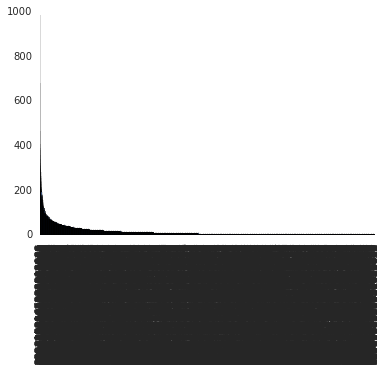

In [183]:
auctions_per_users.plot.bar()

In [145]:
auctions_per_users = auctions_df.othuser_id_64.value_counts()
auctions_per_users_reduced = auctions_per_users[(auctions_per_users >= 1) & (auctions_per_users < 100)]
print(auctions_per_users_reduced.head(3))
print(auctions_per_users_reduced.tail(3))

4863927081331129578    99
6583037023454356045    98
8242175891928723299    97
Name: othuser_id_64, dtype: int64
1226718523590055625    1
5500248918563494612    1
771050609342697791     1
Name: othuser_id_64, dtype: int64


In [146]:
auctions_per_users_reduced[auctions_per_users_reduced == 10].head()

6223814959371480441    10
7140736079851798826    10
550979667177750210     10
6434395744630849171    10
6725637863062274090    10
Name: othuser_id_64, dtype: int64

# ======

In [179]:
usr = auctions_df[auctions_df.othuser_id_64 == 4863927081331129578]#.drop_duplicates() # 2528153167333313088
# usr = usr.drop_duplicates(subset=['advertiser_id', 'start'])

In [168]:
{x: get_most_common(usr[x].tolist()) for x in  ['age', 'operating_systems', 'revenue', 'cpm', 'genders']}

{'age': nan,
 'cpm': 2.9345300000000001,
 'genders': u'u',
 'operating_systems': u'92',
 'revenue': 0.0}

In [165]:
usr.columns

Index([u'advertiser_id', u'campaign_id', u'campaign_group_id',
       u'insertion_order_id', u'othuser_id_64', u'auction_id_64', u'nb_convs',
       u'nb_imps', u'nb_viewed', u'nb_clicks', u'nb_pc_convs', u'nb_pv_convs',
       u'age', u'start', u'end', u'duration', u'revenue', u'cpm',
       u'operating_systems', u'genders', u'member_ids', u'segment_ids',
       u'values', u'nb_daily_unique', u'nb_monthly_unique', u'pixel_ids',
       u'pixels_match', u'pixels_names', u'is_conv_pixel', u'customer_id',
       u'advertiser_categ_whitelist', u'categ', u'd_m', u'd_h',
       u'advertiser_name', u'advertiser_categ', u'campaign_group_name',
       u'insertion_order_name', u'is_traffic_pixel', u'auction_type'],
      dtype='object')

In [180]:
def get_story(user_data):
    # user_data = user_data.sort_values(['advertiser_id', 'start'])
    user_data = user_data.copy()
    previous_adv = None
    user_infos = {x: get_most_common(user_data[x].tolist()) for x in  ['othuser_id_64', 'age', 'operating_systems', 'revenue', 'cpm', 'genders']}
    print('User ({othuser_id_64}) - age {age} - gender {genders} - op {operating_systems} - cpm {cpm} - revenue {revenue}\n\n'.format(
        **user_infos))
    for k, v in user_data.iterrows():
        # v.drop_duplicates(subset=['start'], inplace=True)
        if v['advertiser_id'] != previous_adv:
            previous_adv = v['advertiser_id']
            # v['advertiser_name'] = v.get('advertiser_name').encode('utf-8') or None
            print('== {advertiser_id} ({advertiser_name} - {advertiser_categ} - {advertiser_categ_whitelist} - {categ}) =='.format(**v))
        
        msg = """
        - type: {auction_type} | land: {is_traffic_pixel} | convert: {is_conv_pixel}
        \t- {nb_imps} imps ({viewed:.2f}% viewed) | {nb_clicks} clicks | {nb_convs} convs ({nb_pc_convs}pc, {nb_pv_convs}pv)
        \t- {start} | {end} ({duration}sec - {d_m:.2f}min | {d_h:.2f}h)
        \t- {segment_ids} - daily: {nb_daily_unique} - monthly: {nb_monthly_unique}
        """.format(viewed=v['nb_viewed']*100. / v['nb_imps'], **v)
        print(msg)
    
        # print(v)

In [ ]:
Country_CampaignName_EcoModel_Network_Pixeltype

In [181]:
get_story(usr)

User (4863927081331129578) - age nan - gender u - op None - cpm 2.32 - revenue 0.0


== 558533 (FR_Direct_Mister_Camp - Travel - Consumer Goods & Services - None) ==

        - type: prospecting | land: False | convert: 0
        	- 1 imps (100.00% viewed) | 0 clicks | 0 convs (0pc, 0pv)
        	- 07-09 06:00:01 | 07-09 06:00:01 (0sec - 0.00min | 0.00h)
        	- 5138237 - daily: 1.0 - monthly: 0.0
        
== 581347 (FR_Direct_EBP_FR - Software - Consumer Goods & Services - None) ==

        - type: prospecting | land: False | convert: 0
        	- 1 imps (100.00% viewed) | 0 clicks | 0 convs (0pc, 0pv)
        	- 07-13 09:48:40 | 07-13 09:48:40 (0sec - 0.00min | 0.00h)
        	- None - daily: nan - monthly: nan
        
== 1015504 (FR_Direct_Le_Bus_Direct - Travel - Consumer Goods & Services - None) ==

        - type: retargeting | land: False | convert: 0
        	- 1 imps (100.00% viewed) | 0 clicks | 0 convs (0pc, 0pv)
        	- 07-04 15:14:10 | 07-04 15:14:10 (0sec - 0.00min

In [159]:
from tqdm import tqdm_notebook
from collections import Counter, defaultdict

c = Counter()
adv_saved = defaultdict(set)

groups = auctions_df.groupby(['othuser_id_64', 'advertiser_id'])
for k, v in tqdm_notebook(groups, total=len(groups)):
    # v.sort_values(['start'], inplace=True)
    
    seen = [""]
    for x in v['auction_type'].tolist():
        if not x or x != seen[-1]:
            seen.append(x)

    actions = str(seen[1:])
    
    
    adv_saved[actions].add(k[0])
    if len(seen[1:]) < 6:
        c[actions] += 1

In [204]:
for k,v in adv_saved.items():
    if k.endswith("'retargeting', 'prospecting']") or k.endswith("prospecting_retargeting', 'prospecting'"):
        pass
    else:
        del adv_saved[k]

In [208]:
adv_saved = {k: list(v) for k, v in adv_saved.items()}
with open('./data/adv_saved.json', 'w') as f:
    json.dump(adv_saved, f, indent=4)

In [160]:
d = pd.DataFrame.from_dict(c, 'index')
d.columns = ['count']
d.sort_values('count', ascending=False)

,count
['retargeting'],6921
['prospecting'],3739
"['prospecting', 'prospecting_retargeting']",28
"['retargeting', 'prospecting']",27
"['retargeting', 'prospecting_retargeting']",26
['prospecting_retargeting'],16
"['retargeting', 'prospecting_retargeting', 'retargeting', 'prospecting_retargeting']",16
"['retargeting', 'prospecting_retargeting', 'retargeting']",14
"['prospecting', 'prospecting_retargeting', 'prospecting']",13
"['retargeting', 'prospecting', 'retargeting']",13


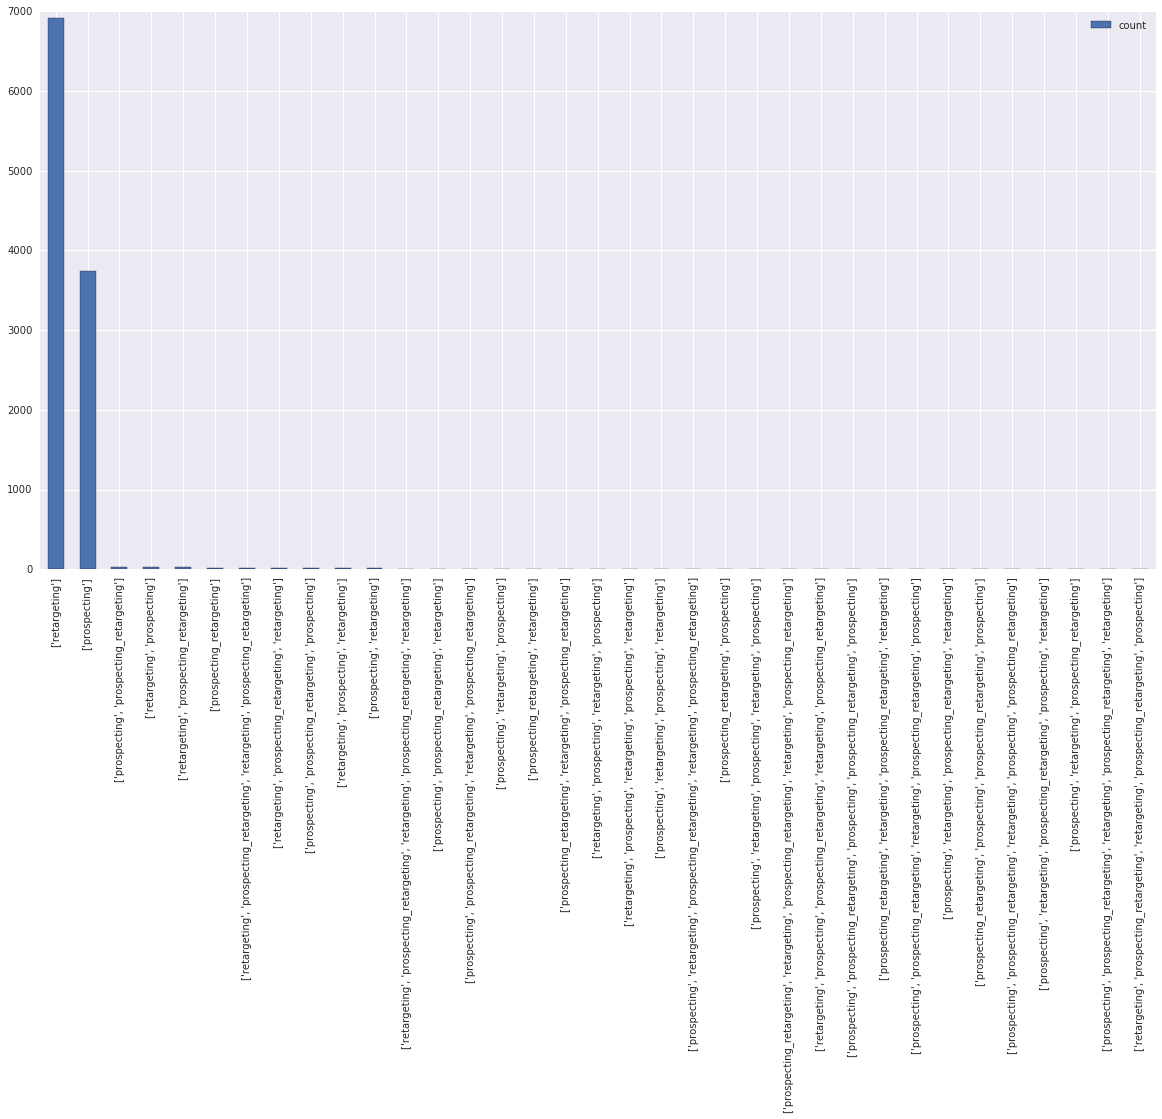

In [161]:
d = pd.DataFrame.from_dict(c, 'index')
d.columns = ['count']
d.sort_values('count', ascending=False).plot.bar(figsize=(20, 10))